In [1]:
import sys
sys.path.append("./scripts/")
from gridmap import *
import math
import copy
from matplotlib.animation import PillowWriter    #アニメーション保存用
neigbor_grids = np.array([[1, 0], [1, 1], [0, 1], [-1, 1], [-1, 0], [-1, -1], [0, -1], [1, -1]])
theta_neigbors = np.array([0, np.pi / 4, np.pi / 2, 3 * np.pi / 4, np.pi, -3 * np.pi / 4, -np.pi / 2, -np.pi / 4])

In [6]:
class BUG():
    def __init__(self, grid_map_world):
        self.world = grid_map_world
        self.grid_map = grid_map_world.grid_map
        self.grid_pair = []
        self.m_line = []
        self.alongObstacle = False
        self.nextObstacle = []
        self.prev_obses = []
        self.neigbor_obs_cans = []
        
        self.nowIndex = self.world.start_index
        self.getMLine()
                
    def getMLine(self):
        index = self.world.start_index
        while(index != self.world.goal_index):
            next_index = copy.copy(index)
            theta_g = np.arctan2(index[1] - self.world.goal_index[1], index[0] - self.world.goal_index[0])
            theta_sort = np.abs((theta_g - theta_neigbors + 2 * np.pi) % (2 * np.pi) - np.pi)
            neigbor_grid = np.argsort(theta_sort)[0]
            next_index = list(index + neigbor_grids[neigbor_grid])
            self.m_line.append(next_index)
            index = next_index
      
    def draw(self, ax, elems):
        if(self.world.goal_index == self.nowIndex):
            pass
        else:
            self.nowIndex = self.next(self.nowIndex, ax, elems)
            if(self.world.goal_index != self.nowIndex):
                self.drawGrid(ax, elems, self.nowIndex, "red")

    def next(self, index, ax, elems):
        next_index = None
        self.prev_obses = []
        # 障害物がない場合の最短経路上に到達した場合
        if(index in self.m_line and self.distance(index, self.world.goal_index) < self.mLine_min):
            next_chk_index = copy.copy(index)
            theta_g = np.arctan2(index[1] - self.world.goal_index[1], index[0] - self.world.goal_index[0])
            theta_sort = np.abs((theta_g - theta_neigbors + 2 * np.pi) % (2 * np.pi) - np.pi)
            flag_obs = False
            neigbor_grid = np.argsort(theta_sort)[0]
            next_chk_index = list(index + neigbor_grids[neigbor_grid])
            if(self.isObstacle(next_chk_index)):
                self.prev_obses.append(next_chk_index)
            else:
                self.alongObstacle = False

        # 障害物がない場合
        if(self.alongObstacle is False):
            next_index = copy.copy(index)
            theta_g = np.arctan2(index[1] - self.world.goal_index[1], index[0] - self.world.goal_index[0])
            theta_sort = np.abs((theta_g - theta_neigbors + 2 * np.pi) % (2 * np.pi) - np.pi)
            flag_obs = False
            neigbor_grid = np.argsort(theta_sort)[0]
            next_index = list(index + neigbor_grids[neigbor_grid])
            if(self.isObstacle(next_index)):
                self.alongObstacle = True
                self.prev_obses.append(next_index)
            else:
                self.mLine_min = self.distance(self.world.goal_index, index)
                return next_index
            
        # 前回接触した障害物に隣接する障害物をリストアップ
        for grid in neigbor_grids:
            neigbor_obs = [grid[0] + index[0], grid[1] + index[1]]
            if(self.isObstacle(neigbor_obs) and neigbor_obs in self.neigbor_obs_cans):
                self.prev_obses.append(neigbor_obs)
            elif(len(self.neigbor_obs_cans) > 0 and self.isConnectObstacle(neigbor_obs, self.neigbor_obs_cans)):
                self.prev_obses.append(neigbor_obs)
        
        # 障害物に沿って移動する場合
        if(self.alongObstacle is True):
            next_robot_candidate = []
            if(next_index is not None):
                neigbor_obs_cans = []
                for prev_obs in self.prev_obses:
                    neigbor_obs_cans.append(prev_obs)
                    for grid in neigbor_grids:
                        neigbor_obs = [prev_obs[0] + grid[0], prev_obs[1] + grid[1]]
                        if not(neigbor_obs in neigbor_obs_cans):
                            neigbor_obs_cans.append(neigbor_obs)
                for neigbor_obs_can in neigbor_obs_cans:
                    if(self.isObstacle(neigbor_obs_can)):
                        for grid2 in neigbor_grids:
                            neigbor_robot_can = [index[0] + grid2[0], index[1] + grid2[1]]
                            if(self.isNeigbor(neigbor_obs_can, neigbor_robot_can) and not(self.isObstacle(neigbor_robot_can))):
                                next_robot_candidate.append([neigbor_robot_can, neigbor_obs_can])
                next_index = next_robot_candidate[0][0]
            else:
                neigbor_obs_cans = []
                
                # トラックすべき障害物をリストアップ
                for prev_obs in self.prev_obses:
                    neigbor_obs_cans.append(prev_obs)
                    for grid in neigbor_grids:
                        neigbor_obs = [prev_obs[0] + grid[0], prev_obs[1] + grid[1]]
                        if(self.isConnectObstacle(prev_obs, [neigbor_obs])):
                            neigbor_obs_cans.append(neigbor_obs)

                # 隣接する障害物と接し，かつロボットが移動できるグリッドをリストアップする
                for neigbor_obs_can in neigbor_obs_cans:
                    if(self.isObstacle(neigbor_obs_can)):
                        for grid2 in neigbor_grids:
                            neigbor_robot_can = [index[0] + grid2[0], index[1] + grid2[1]]
                            if(self.isNeigbor(neigbor_obs_can, neigbor_robot_can) and not(self.isObstacle(neigbor_robot_can))):
                                next_robot_candidate.append([neigbor_robot_can, neigbor_obs_can])
                
                # ロボットが移動できるグリッドの候補から過去の移動していない場所を求める
                goal_dis = float('inf')
                for r_grid, c_grid in next_robot_candidate:
                    if([r_grid, c_grid] in self.grid_pair):
                        continue
                    else:
                        chk_index = r_grid
                        if(goal_dis > self.distance(chk_index, self.world.goal_index)):
                            goal_dis = self.distance(chk_index, self.world.goal_index)
                        next_index = chk_index
                
                # 角を素通りした場合，その角を移動済みとして処理する
                goal_dis = float('inf')
                if(abs(index[0] - next_index[0]) + abs(index[1] - next_index[1]) > 1.5):
                    passed_indices = [[min(index[0], next_index[0]), max(index[1], next_index[1])], [max(index[0], next_index[0]), min(index[1], next_index[1])]]
                    if(index in passed_indices):
                        passed_indices = [[min(index[0], next_index[0]), min(index[1], next_index[1])], [max(index[0], next_index[0]), max(index[1], next_index[1])]]
                    for passed_index in passed_indices:
                        for grid in neigbor_grids:
                            chk_obs = [passed_index[0] + grid[0], passed_index[1] + grid[1]]
                            if(self.isObstacle(chk_obs) and self.isConnectObstacle(chk_obs, neigbor_obs_cans)):
                                self.grid_pair.append([passed_index, chk_obs])
                        if(passed_index in self.m_line):
                            if(goal_dis > self.distance(passed_index, self.world.goal_index) and not(self.isObstacle(passed_index))):
                                goal_dis = self.distance(passed_index, self.world.goal_index)
                                next_index = passed_index

            for grid in neigbor_grids:
                neigbor_grid = [grid[0] + index[0], grid[1] + index[1]]
                if(self.isObstacle(neigbor_grid)):
                    self.grid_pair.append([index, neigbor_grid])
            self.neigbor_obs_cans = neigbor_obs_cans
        return next_index
    
    def drawGrid(self, ax, elems, grid, color, alpha=0.5):
        r = patches.Rectangle(
            xy=((grid[0])*self.world.grid_step[0], (grid[1])*self.world.grid_step[1]),
            height=self.world.grid_step[0],
            width=self.world.grid_step[1],
            color=color,
            fill=True,
            alpha=alpha
        )
        #elems.append(ax.add_patch(r))
        ax.add_patch(r)
        
    def isObstacle(self, index):
        if(index[0] > self.world.grid_map.shape[0] - 1 or index[1] > self.world.grid_map.shape[1] - 1 or index[0] < 0 or index[1] < 0):
            return True
        if(self.world.grid_map[index[0]][index[1]] == '0'):
            return True
        else:
            return False
    
    def isNeigbor(self, index1, index2):
        dx = index1[0] - index2[0]
        dy = index1[1] - index2[1]
        if(math.sqrt(dx**2 + dy**2) <= math.sqrt(2)):
            return True
        else:
            return False
        
    def isNeigborObstacle(self, index):
        for neigbor_grid in neigbor_grids:
            if(self.isObstacle([neigbor_grid[0] + index[0], neigbor_grid[1] + index[1]])):
                return True
        return False
    
    def isConnectObstacle(self, index1, indices):
        if not(self.isObstacle(index1)):
            return False
        for index in indices:
            if not(self.isObstacle(index)):
                return False
        open_list = [index1]
        closed_list = []
        flag = False
        while(len(open_list) > 0):
            chk_index = open_list[0]
            for grid in neigbor_grids:
                new_index = [chk_index[0]+grid[0], chk_index[1]+grid[1]]
                if(new_index[0] < 0 or new_index[1] < 0 or new_index[0] > self.world.grid_map.shape[0] - 1 or new_index[1] > self.world.grid_map.shape[1] - 1):
                    continue
                if(self.isObstacle(new_index) and not(new_index in closed_list) and not(new_index in open_list)):
                    open_list.append(new_index)
            open_list.remove(chk_index)
            closed_list.append(chk_index)
            for index in indices:
                if(index in open_list):
                    flag = True
                    return True
        return flag
    
    def distance(self, index1, index2):
        dx = index1[0] - index2[0]
        dy = index1[1] - index2[1]
        return np.sqrt(dx**2 + dy**2)

<IPython.core.display.Javascript object>


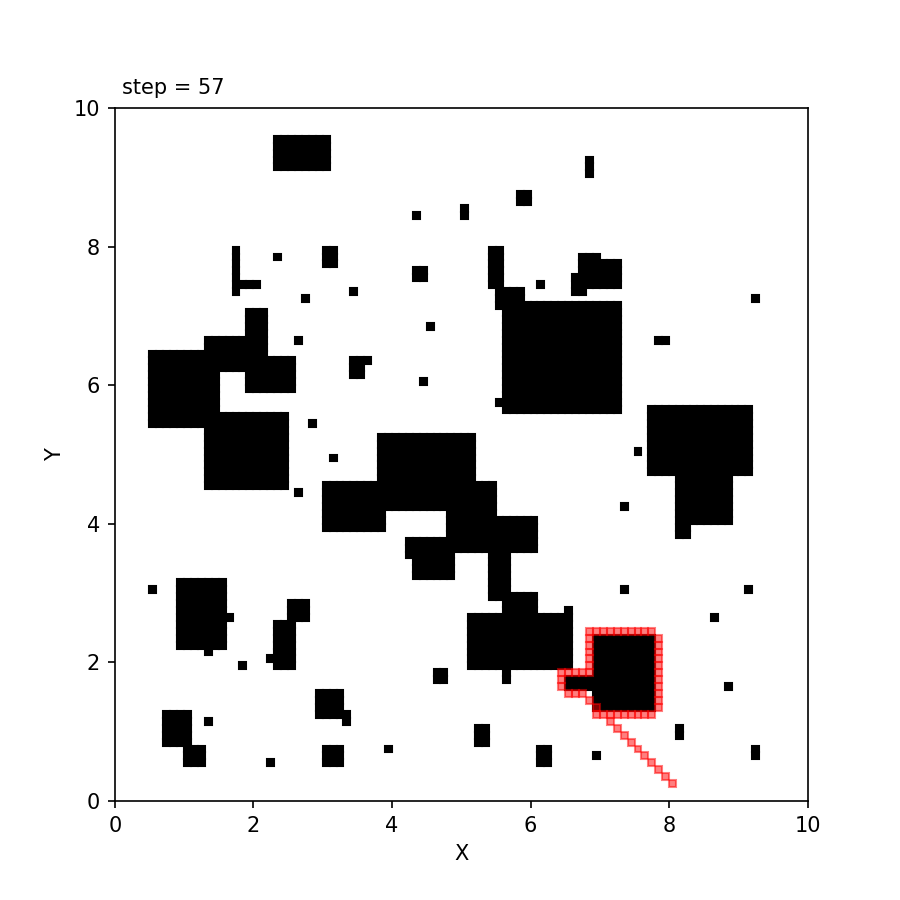

In [7]:
if __name__ == "__main__":
    time_span = 100
    time_interval = 0.01
    
    grid_step = np.array([0.1, 0.1])
    grid_num = np.array([100, 100])
    
    map_data = "./csvmap/map_rl.csv"
    
    world = GridMapWorld(grid_step, grid_num, time_span, time_interval, map_data, debug=False)
    world.start_index = [81, 1] 
    world.goal_index = [5, 66]
    world.append(BUG(world))
    
    world.draw()
    #world.ani.save('bug_map.gif', writer='pillow', fps=100)    #アニメーション保存